## EXPERIMENT 1: 
Our dense neural network will consist of 784 input nodes, a hidden layer with 1 nodeand 10 output nodes (corresponding to the 10 digits). 

We use mnist.load_data() to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. 

After training the model, we group the 60,000 activation valuesof the hidden node for the (original) set of training images by the 10 labels of the images that generated them and visualize these sets of values using a boxplot. 

We expect to see substantial overlap between the range of values in the "boxes" reflecting the fact that the activation values of the hidden node are not able to discriminate between the classes. 

In addition, we find the pattern that maximally activates the hidden node as a "warm up" exercise for similar analysis we will perform on CNN models in Assignment 2.

### Import Packages

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib as mpl  # EA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
#from plot_keras_history import plot_history

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True) 

### Verify TensorFlow version and Keras version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.7.0


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.7.0


### Mount Google Drive to Colab environment

In [5]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Functions For Research Assignment 

In [6]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Loading MNIST Dataset

* The MNIST dataset of handwritten digits has a training set of 60,000 images, and a test set of 10,000 images. It comes prepackaged as part of `tf.Keras`. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [8]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


* Tuples of Numpy arrays: `(x_train, y_train)`, `(x_test, y_test)`
* `x_train`, `x_test`: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* `y_train`, `y_test`: uint8 arrays of digit labels (integers in range 0-9)

### EDA Training and Test Sets

* Inspect the training and test sets as well as their labels as follows.

In [9]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


### Plot sample images with their labels

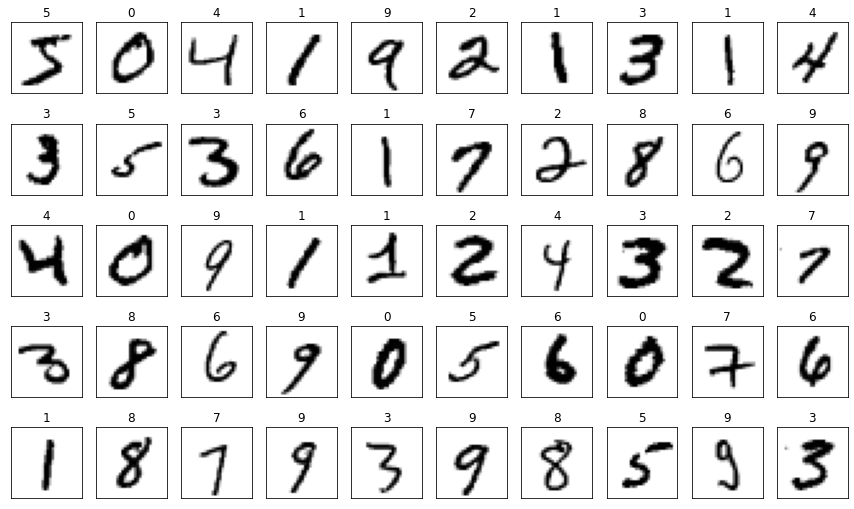

In [10]:
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

### Preprocessing Data

* Before we build our model, we need to prepare the data into the shape the network expected
* More specifically, we will convert the labels (integers 0 to 9) to 1D numpy arrays of shape (10,) with elements 0s and 1s. 
* We also reshape the images from 2D arrays of shape (28,28) to 1D *float32* arrays of shape (784,) and then rescale their elements to values between 0 and 1.

### Apply one-hot encoding on the labels

We will change the way the labels are represented from numbers (0 to 9) to vectors (1D arrays) of shape (10, ) with all the elements set to 0 except the one which the label belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0 0 0 0 0 1 0 0 0 0] |
| 7 | [0 0 0 0 0 0 0 1 0 0] |
| 1 | [0 1 0 0 0 0 0 0 0 0] |

In [11]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [12]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


### Reshape the images to 1D arrays

Reshape the images from shape (28, 28) 2D arrays to shape (784, ) vectors (1D arrays).

In [13]:
# Before reshape:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [14]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [15]:
# Reshape the images:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

# After reshape:
print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in an image is a pixel value
2. Pixel values range from 0 to 255
3. 0 = White
4. 255 = Black

### Review unique values with set from 1st image

In [16]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


### Rescale the elements of the reshaped images

Rescale the elements between [0 and 1]

In [17]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [18]:
# Take a look at the first reshaped and normalized training image:
print(set(x_train_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.7882353, 0.52156866, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.88235295, 0.99215686, 0.9490196, 0.7647059, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.98039216, 0.73333335, 0.42352942, 0.003921569, 0.54509807, 0.67058825, 0.5294118, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.627451, 0.9411765, 0.9882353, 0.95686275, 0.83137256, 0.5176471, 0.09803922, 0.1764706}


### Build the DNN model

We use a `Sequential` class defined in `Keras` to create our model. All the layers are going to be Dense layers. This means, like the figure shown above, all the nodes of a layer would be connected to all the nodes of the preceding layer i.e. densely connected.

After the model is built, we view ....

In [19]:
model = Sequential([
    Dense(input_shape=[784], units=1, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 785       
                                                                 
 output_layer (Dense)        (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


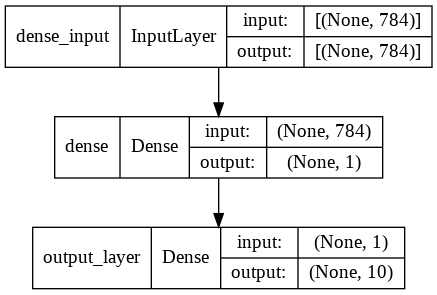

In [21]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

### Compile the DNN model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimized in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimizes the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.


<b>tf.keras.optimizers.RMSprop</b><br> 
 https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop


<b>tf.keras.losses.CategoricalCrossentropy</b><br> 
  https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy


In [22]:
model.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

### Validating the approach

We hold back 5,000 of the 60,000 training images for validation.

In [23]:
x_val = x_train_norm[:5000]
partial_x_train = x_train_norm[5000:]
y_val = y_train_encoded[:5000]
partial_y_train = y_train_encoded[5000:]

### Train the DNN model

<b>tf.keras.model.fit</b><br>
  https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [24]:
history = model.fit(
    partial_x_train
    ,partial_y_train
    ,epochs = 200
    ,batch_size=512
    ,validation_data=(x_val, y_val)
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

Epoch 1/200
108/108 [==============================] - 3s 6ms/step - loss: 2.1928 - accuracy: 0.1775 - val_loss: 2.1211 - val_accuracy: 0.1782
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 2.0923 - accuracy: 0.1903 - val_loss: 2.0577 - val_accuracy: 0.1932
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 2.0447 - accuracy: 0.1985 - val_loss: 2.0234 - val_accuracy: 0.2014
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 2.0150 - accuracy: 0.2071 - val_loss: 1.9987 - val_accuracy: 0.2068
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.9923 - accuracy: 0.2122 - val_loss: 1.9773 - val_accuracy: 0.2154
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.9726 - accuracy: 0.2163 - val_loss: 1.9573 - val_accuracy: 0.2188
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.9551 - accuracy: 0.2207 - val_loss: 1.9398 - val_accuracy: 0.2320

### Evaluate the DNN model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [25]:
loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 1.9016 - accuracy: 0.2383
test set accuracy:  23.829999566078186


### Making Predictions

In [26]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


Look at the first 25 - Plot test set images along with their predicted and actual labels to understand how the trained model actually performed

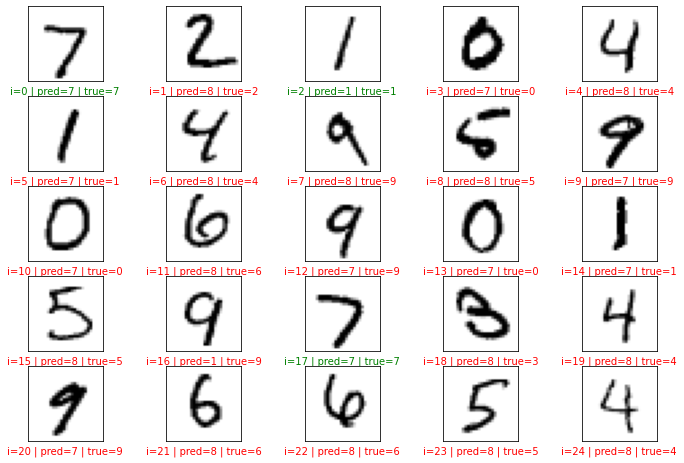

In [27]:
plt.figure(figsize = (12, 8))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

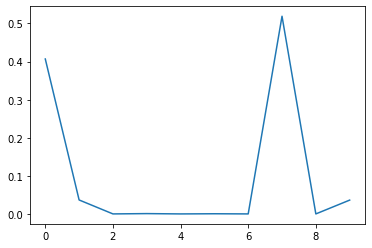

In [28]:
"""
Enter the index value in place of the value 17 below for the prediction
that you want to plot the probability scores for
"""
index = 17

plt.plot(preds[index])
plt.show()

### Reviewing Performance

In [29]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plot performance metrics 

We use `Matplotlib` to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

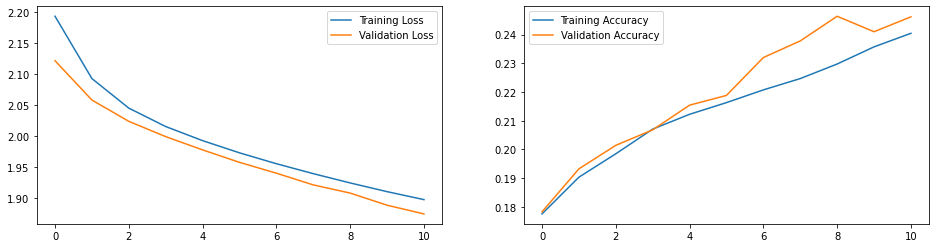

In [32]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [33]:
pred1= model.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

In [34]:
print_validation_report(y_test, pred1)

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.31      0.53      0.40      1135
           2       0.06      0.01      0.01      1032
           3       0.16      0.07      0.10      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.35      0.87      0.50      1028
           8       0.16      0.82      0.27       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.24     10000
   macro avg       0.11      0.23      0.13     10000
weighted avg       0.11      0.24      0.13     10000

Accuracy Score: 0.2383
Root Mean Square Error: 4.309686763559505


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Create the confusion matrix

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [35]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_test_norm), axis=-1)
pred_classes;

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [36]:
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

In [37]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9
0,39.43%,5.85%,0.01%,0.23%,0.00%,0.13%,0.01%,48.59%,0.00%,5.74%
1,2.27%,8.08%,14.32%,12.03%,14.43%,11.09%,13.54%,2.24%,14.52%,7.48%
2,18.51%,20.35%,2.40%,7.94%,1.28%,6.11%,2.26%,19.85%,2.05%,19.24%
3,40.59%,3.85%,0.00%,0.09%,0.00%,0.05%,0.00%,51.60%,0.00%,3.81%
4,2.27%,8.08%,14.32%,12.03%,14.43%,11.09%,13.54%,2.24%,14.52%,7.48%
5,20.82%,20.07%,1.75%,6.74%,0.87%,5.08%,1.64%,22.53%,1.47%,19.02%
6,2.27%,8.08%,14.32%,12.03%,14.43%,11.09%,13.54%,2.24%,14.52%,7.48%
7,2.27%,8.08%,14.32%,12.03%,14.43%,11.09%,13.54%,2.24%,14.52%,7.48%
8,2.27%,8.08%,14.32%,12.03%,14.43%,11.09%,13.54%,2.24%,14.52%,7.48%
9,33.70%,12.54%,0.12%,1.43%,0.04%,0.93%,0.11%,38.96%,0.09%,12.09%


### Visualize the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

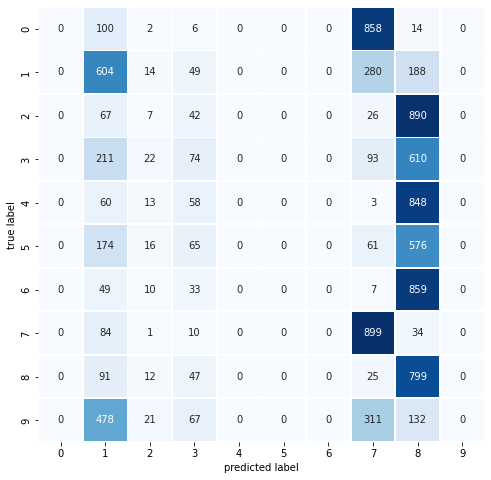

In [38]:
plot_confusion_matrix(y_test,pred_classes)

 ### Get the activation values of the hidden nodes
 
To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [39]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 2 layers


In [40]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 1)

In [41]:
output_layer_activations.shape

(60000, 10)

In [42]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 11.952302932739258


In [43]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.129 0.194 0.047 0.108 0.03  0.087 0.044 0.136 0.042 0.183]
The sum of the probabilities is (approximately) 1.0


 ### Create a dataframe with the activation values and the class labels

In [44]:
hidden_layer_activation.shape

(60000, 1)

In [45]:
#Get the dataframe of all the node values
activation_data = {'actual_class':y_train}
for k in range(0,1): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.000,0.000,4.0,1.000,9.000,2.000,1.00,3.0,1.000,4.0,3.000,5.0,3.0,6.0,1.000
act_val_0,1.754,7.515,0.0,0.179,3.574,0.221,1.12,0.0,1.848,0.0,1.972,0.0,0.0,0.0,1.588


 ### Visualize the activation values with boxplots
 
We get the activation values of the first hidden node and combine them with the corresponding class labels into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe. 

<div class="alert alert-block alert-info">
    <b>seaborn.boxplot</b><br> 
   ps://seaborn.pydata.org/generated/seaborn.boxplot.html
    </div>

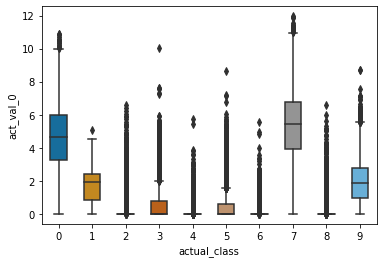

In [46]:
# To see how closely the hidden node activation values correlate with the class labels
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='actual_class', 
                 data=activation_df[['act_val_0','actual_class']], 
                 width=0.5,
                 palette="colorblind")

In [47]:
# displaying the range of activation values for each class labels
activation_df.groupby("actual_class")["act_val_0"].apply(lambda x: [round(min(x.tolist()),2),
 round(max(x.tolist()),2)]).reset_index().rename(columns={"act_val_0": "range_of_act_values"})

,actual_class,range_of_act_values
0,0,"[0.0, 10.9]"
1,1,"[0.0, 5.05]"
2,2,"[0.0, 6.6]"
3,3,"[0.0, 10.04]"
4,4,"[0.0, 5.74]"
5,5,"[0.0, 8.67]"
6,6,"[0.0, 5.54]"
7,7,"[0.0, 11.95]"
8,8,"[0.0, 6.6]"
9,9,"[0.0, 8.71]"


## EXPERIMENT 2: 
This time our dense neural network will have 784 input nodes, a hidden layer with 2 nodes and 10 output nodes (corresponding to the 10 digits). 

For each of the 60,000 images, the output of the two hidden nodes are plotted using a scatterplot. 

We color code the points according to the class label of the image. Just like in EXPERIMENT 1, the color clusters should have substantial overlap. Also compare the accuracy % & confusion matrix of Experiments 1 & 2. Again, the goal is to get more insights.

In [48]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [49]:
model_exp2 = Sequential([
    Dense(2, input_shape=[784], activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), 
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

model_exp2.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

history_exp2 = model_exp2.fit(
    partial_x_train
    ,partial_y_train
    ,epochs = 200
    ,batch_size=512
    ,validation_data=(x_val, y_val)
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

loss, accuracy = model_exp2.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

Epoch 1/200
108/108 [==============================] - 1s 5ms/step - loss: 2.0081 - accuracy: 0.2468 - val_loss: 1.8612 - val_accuracy: 0.2986
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.8009 - accuracy: 0.3203 - val_loss: 1.7348 - val_accuracy: 0.3450
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 1.7049 - accuracy: 0.3478 - val_loss: 1.6589 - val_accuracy: 0.3670
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.6403 - accuracy: 0.3642 - val_loss: 1.6002 - val_accuracy: 0.3714
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5833 - accuracy: 0.3852 - val_loss: 1.5393 - val_accuracy: 0.4530
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 1.5228 - accuracy: 0.4652 - val_loss: 1.4813 - val_accuracy: 0.4706
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 1.4707 - accuracy: 0.4892 - val_loss: 1.4345 - val_accuracy: 0.5122

shape of preds:  (10000, 10)


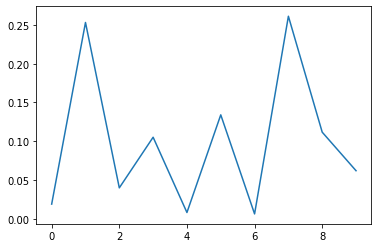

In [50]:
preds = model_exp2.predict(x_test_norm)
print('shape of preds: ', preds.shape)

index = 17
plt.plot(preds[index])
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 1152x288 with 0 Axes>

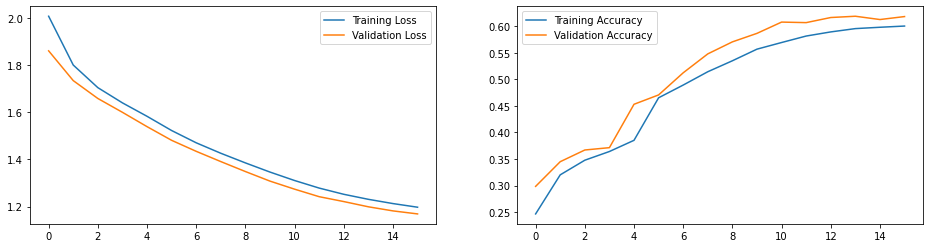

Classification Report
              precision    recall  f1-score   support

           0       0.49      0.82      0.61       980
           1       0.80      0.94      0.86      1135
           2       0.22      0.08      0.11      1032
           3       0.52      0.75      0.61      1010
           4       0.68      0.74      0.71       982
           5       0.32      0.32      0.32       892
           6       0.73      0.87      0.80       958
           7       0.75      0.79      0.77      1028
           8       0.50      0.10      0.17       974
           9       0.59      0.49      0.53      1009

    accuracy                           0.60     10000
   macro avg       0.56      0.59      0.55     10000
weighted avg       0.56      0.60      0.56     10000

Accuracy Score: 0.5954
Root Mean Square Error: 2.4475497952033582


array([7, 0, 1, ..., 4, 5, 6])

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 800,    0,   37,   34,    1,   38,   61,    1,    7,    1],
       [   0, 1071,    2,   42,    0,   15,    0,    3,    1,    1],
       [ 500,    6,   80,  209,   15,   86,   92,    8,   22,   14],
       [  36,  131,    8,  755,    0,   54,    0,   21,    4,    1],
       [   0,    0,    1,    0,  725,   10,   51,   17,    5,  173],
       [ 121,   43,   89,  235,    2,  281,   34,   23,   44,   20],
       [  35,    1,   26,    2,   36,   11,  832,    0,   11,    4],
       [   0,   51,    1,   13,    7,   31,    4,  814,    5,  102],
       [ 139,   30,  125,  152,    5,  336,   43,   13,  102,   29],
       [  10,   11,    1,    7,  269,   14,   17,  183,    3,  494]], dtype=int32)>

,0,1,2,3,4,5,6,7,8,9
0,1.30%,5.34%,3.06%,3.27%,7.16%,8.75%,1.43%,35.92%,8.15%,25.62%
1,49.40%,0.00%,27.79%,2.48%,0.00%,9.63%,0.92%,0.00%,9.78%,0.00%
2,0.51%,75.82%,0.86%,14.30%,0.00%,4.04%,0.01%,1.73%,2.68%,0.04%
3,45.26%,0.00%,30.08%,1.01%,0.00%,9.18%,3.87%,0.00%,10.60%,0.00%
4,0.50%,0.00%,1.10%,0.04%,54.78%,1.05%,7.24%,1.66%,1.41%,32.23%
5,0.46%,77.25%,0.77%,13.98%,0.00%,3.65%,0.01%,1.45%,2.40%,0.03%
6,1.00%,0.02%,2.24%,0.27%,35.53%,3.23%,5.49%,7.31%,3.79%,41.13%
7,1.41%,1.15%,3.27%,1.79%,13.78%,7.59%,2.55%,25.97%,7.59%,34.89%
8,5.11%,0.00%,7.06%,0.02%,10.93%,2.25%,65.52%,0.07%,3.64%,5.40%
9,1.13%,0.05%,2.57%,0.44%,30.22%,4.12%,4.86%,10.23%,4.66%,41.71%


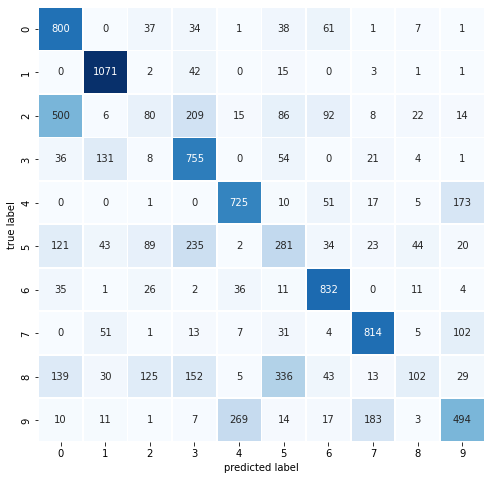

In [51]:
history_dict = history_exp2.history
history_dict.keys()

losses = history_exp2.history['loss']
accs = history_exp2.history['accuracy']
val_losses = history_exp2.history['val_loss']
val_accs = history_exp2.history['val_accuracy']
epochs = len(losses)


plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()


pred1= model_exp2.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)


pred_classes = np.argmax(model_exp2.predict(x_test_norm), axis=-1)
pred_classes;
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

plot_confusion_matrix(y_test,pred_classes)

There are 2 layers


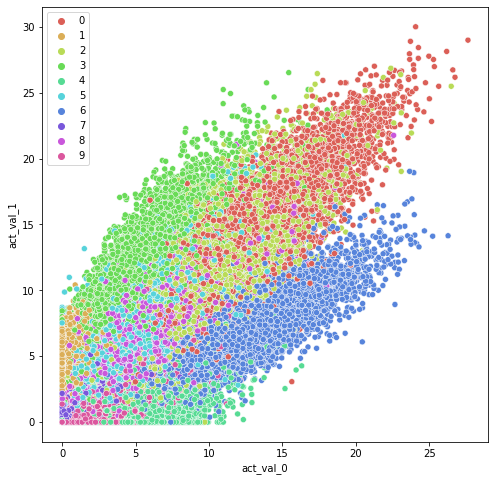

In [52]:
layer_outputs = [layer.output for layer in model_exp2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_exp2.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 2 hidden nodes has one activation value per training image


activation_data = {'actual_class':y_train}
for k in range(0,2): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T


plt.figure(figsize=(8, 8))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="act_val_0", y="act_val_1", hue="actual_class",  palette=color, data = activation_df, legend="full")
plt.legend(loc='upper left');

## EXPERIMENT 3: 
You can explore with more hidden nodes. Then end up with 1 ‘final’ model. Say the ‘best’ model.

In [83]:
def createmodel(hidden_layer_nodes):
    model = Sequential([
        Dense(input_shape=[784], units=hidden_layer_nodes, activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
        Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
    ])
    model.compile(optimizer='rmsprop',           
                   loss = 'categorical_crossentropy',
                   metrics=['accuracy']) 
    history_explore = model.fit(
      partial_x_train
      ,partial_y_train
      ,epochs = 200
      ,batch_size=512
      ,validation_data=(x_val, y_val)
      ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
      )
    return model


In [90]:
num_hidden_nodes_explore =[1,2,10,50,128,256]
accuracy_explore =[]
runtime_explore =[]
import datetime as dt


for num_nodes in num_hidden_nodes_explore:
  start_datetime = dt.datetime.now()
  model_explore = createmodel(num_nodes)
  loss, accuracy = model_explore.evaluate(x_test_norm, y_test_encoded)
  runtime = (dt.datetime.now() - start_datetime).total_seconds()
  #runtime_per_epoch = runtime/epochs
  print('number of hidden nodes: ', num_nodes)
  print('test set accuracy: ', accuracy * 100)
  print('runtime: ', runtime)
  accuracy_explore.append(accuracy*100)
  runtime_explore.append(runtime)

Epoch 1/200
108/108 [==============================] - 1s 5ms/step - loss: 2.2187 - accuracy: 0.1866 - val_loss: 2.1543 - val_accuracy: 0.1988
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 2.1134 - accuracy: 0.2007 - val_loss: 2.0532 - val_accuracy: 0.2074
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 2.0353 - accuracy: 0.2052 - val_loss: 1.9888 - val_accuracy: 0.2166
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 1.9837 - accuracy: 0.2049 - val_loss: 1.9461 - val_accuracy: 0.2072
Epoch 5/200
313/313 [==============================] - 1s 2ms/step - loss: 1.9368 - accuracy: 0.2099
number of hidden nodes:  1
test set accuracy:  20.990000665187836
runtime:  4.410032
Epoch 1/200
108/108 [==============================] - 1s 5ms/step - loss: 2.1246 - accuracy: 0.2723 - val_loss: 1.9514 - val_accuracy: 0.3690
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 1.8526 - accuracy: 0.378

Text(0.5, 0, 'Number of Hidden Nodes')

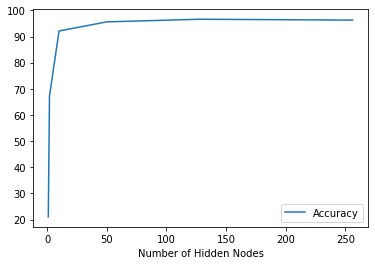

In [95]:
#plot accuracy by num_hidden_nodes
import matplotlib.pyplot as plt

plt.plot(num_hidden_nodes_explore, accuracy_explore, label ='Accuracy')
#plt.scatter(num_hidden_nodes_explore, runtime_explore, label = "Runtime(Second)")
plt.legend()
plt.xlabel("Number of Hidden Nodes")
plt.show()

In [53]:
# model with 128 hidden nodes
model_exp3 = Sequential([
    Dense(128, input_shape=[784], activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), 
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

model_exp3.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

history_exp3 = model_exp3.fit(
    partial_x_train
    ,partial_y_train
    ,epochs = 200
    ,batch_size=512
    ,validation_data=(x_val, y_val)
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

loss, accuracy = model_exp3.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

Epoch 1/200
108/108 [==============================] - 1s 6ms/step - loss: 0.6700 - accuracy: 0.8627 - val_loss: 0.4067 - val_accuracy: 0.9188
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 0.3765 - accuracy: 0.9254 - val_loss: 0.3278 - val_accuracy: 0.9384
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 0.3115 - accuracy: 0.9394 - val_loss: 0.3019 - val_accuracy: 0.9400
Epoch 4/200
108/108 [==============================] - 0s 4ms/step - loss: 0.2702 - accuracy: 0.9488 - val_loss: 0.2619 - val_accuracy: 0.9468
Epoch 5/200
108/108 [==============================] - 0s 4ms/step - loss: 0.2414 - accuracy: 0.9547 - val_loss: 0.2386 - val_accuracy: 0.9570
Epoch 6/200
108/108 [==============================] - 0s 4ms/step - loss: 0.2201 - accuracy: 0.9587 - val_loss: 0.2079 - val_accuracy: 0.9642
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 0.2043 - accuracy: 0.9632 - val_loss: 0.1947 - val_accuracy: 0.9668

shape of preds:  (10000, 10)


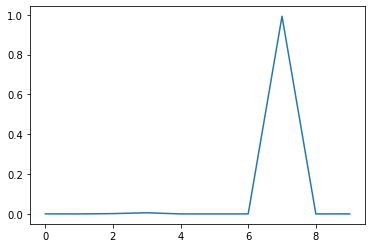

In [54]:
preds = model_exp3.predict(x_test_norm)
print('shape of preds: ', preds.shape)

index = 17
plt.plot(preds[index])
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 1152x288 with 0 Axes>

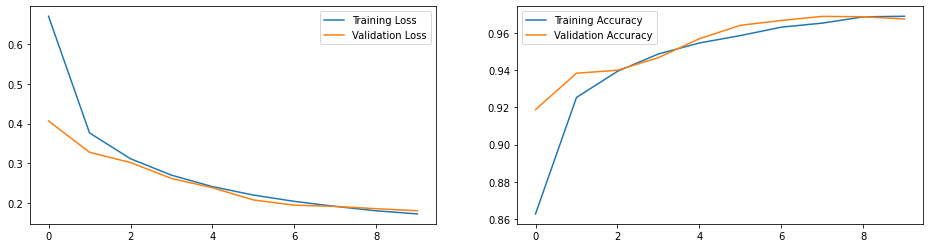

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.98      0.96      1032
           3       0.92      0.98      0.95      1010
           4       0.98      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.98      0.93      0.95       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000

Accuracy Score: 0.9647
Root Mean Square Error: 0.83916625289629


array([7, 2, 1, ..., 4, 5, 6])

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 968,    0,    2,    2,    0,    4,    2,    1,    1,    0],
       [   0, 1122,    3,    1,    0,    1,    4,    1,    3,    0],
       [   3,    2, 1014,    3,    0,    0,    2,    6,    2,    0],
       [   0,    0,    8,  991,    0,    2,    0,    5,    3,    1],
       [   1,    1,    7,    0,  940,    1,    4,    1,    2,   25],
       [   2,    1,    1,   20,    1,  855,    6,    1,    4,    1],
       [   6,    3,    3,    1,    6,    8,  929,    0,    2,    0],
       [   1,   10,   21,    9,    2,    1,    0,  975,    0,    9],
       [   2,    2,   11,   30,    4,   11,    6,    5,  901,    2],
       [   3,    7,    3,   19,   10,    6,    1,    6,    2,  952]], dtype=int32)>

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.10%,0.47%,0.00%,0.00%,0.00%,99.39%,0.00%,0.03%
1,0.01%,0.02%,99.57%,0.37%,0.00%,0.01%,0.01%,0.00%,0.02%,0.00%
2,0.00%,98.99%,0.38%,0.13%,0.02%,0.05%,0.09%,0.22%,0.11%,0.00%
3,99.71%,0.00%,0.19%,0.02%,0.00%,0.06%,0.01%,0.01%,0.00%,0.00%
4,0.02%,0.00%,0.15%,0.01%,95.86%,0.02%,0.12%,0.10%,0.10%,3.62%
5,0.00%,99.66%,0.04%,0.05%,0.00%,0.00%,0.00%,0.22%,0.02%,0.00%
6,0.00%,0.00%,0.00%,0.04%,95.52%,0.13%,0.02%,0.13%,3.41%,0.74%
7,0.00%,0.15%,0.72%,3.04%,0.83%,0.20%,0.00%,0.19%,0.38%,94.49%
8,0.46%,0.01%,21.97%,0.01%,0.10%,15.84%,60.54%,0.00%,0.98%,0.10%
9,0.00%,0.00%,0.00%,0.05%,2.13%,0.01%,0.00%,1.54%,0.59%,95.69%


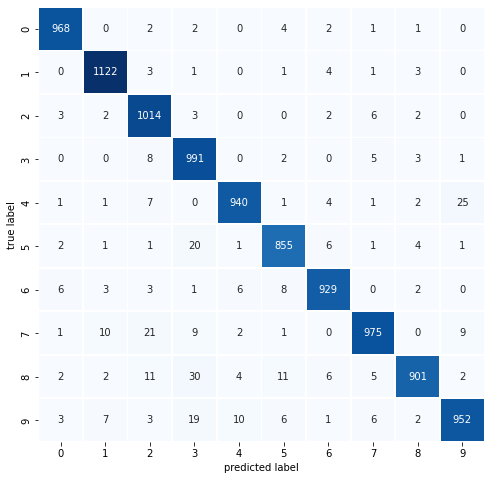

In [55]:
history_dict = history_exp3.history
history_dict.keys()

losses = history_exp3.history['loss']
accs = history_exp3.history['accuracy']
val_losses = history_exp3.history['val_loss']
val_accs = history_exp3.history['val_accuracy']
epochs = len(losses)


plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()


pred1= model_exp3.predict(x_test_norm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)


pred_classes = np.argmax(model_exp3.predict(x_test_norm), axis=-1)
pred_classes;
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

plot_confusion_matrix(y_test,pred_classes)

There are 2 layers


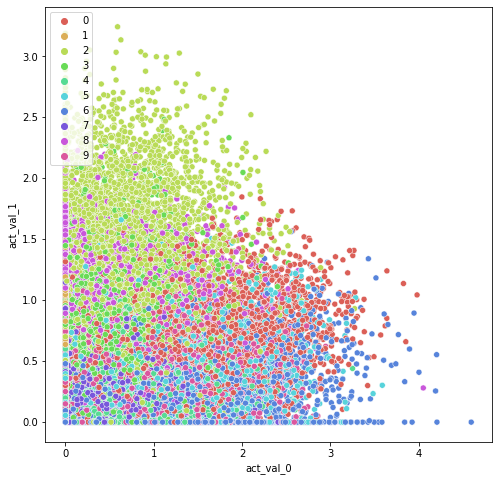

In [56]:
layer_outputs = [layer.output for layer in model_exp3.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_exp3.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 12 8 hidden nodes has one activation value per training image


activation_data = {'actual_class':y_train}
for k in range(0,128): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T


plt.figure(figsize=(8, 8))
color = sns.color_palette("hls", 10)
sns.scatterplot(x="act_val_0", y="act_val_1", hue="actual_class",  palette=color, data = activation_df, legend="full")
plt.legend(loc='upper left');

## EXPERIMENT 4: 
Use PCA decomposition to reduce the number of dimensions of our training set of 28x28 dimensional MNIST images from 784 to 154 (with 95% of training images variance lying along these components). We also reduce the number of dimensions of 'best' model from Experiment 3 to 154 inputs nodes and train it on the new lower dimensional data. We then compare the performance of Experiments 3 and 4.

### Use PCA decomposition to reduce the number of features from 784 features to 154 features 

In [57]:
x_train_norm.shape

feature_data = {'actual_class':y_train}
for k in range(0,784): 
    feature_data[f"feature_{k}"] = x_train_norm[:,k]
feature_df = pd.DataFrame(feature_data)
feature_df.head(15).round(3).T


(60000, 784)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,5.0,0.0,4.0,1.0,9.0,2.0,1.0,3.0,1.0,4.0,3.0,5.0,3.0,6.0,1.0
feature_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature_782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Separating out the features
features = [*feature_data][1:] 
x = feature_df.loc[:, features].values 

pca = PCA(n_components=154)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents)

In [59]:

#feature_pca_df = pd.concat([principalDf, feature_df[['actual_class']]], axis = 1)
#feature_pca_df.head().round(3)
#feature_pca_df.shape

In [60]:
pca.explained_variance_ratio_

array([0.097, 0.071, 0.062, 0.054, 0.049, 0.043, 0.033, 0.029, 0.028, 0.024, 0.021, 0.02 , 0.017, 0.017, 0.016, 0.015, 0.013, 0.013, 0.012, 0.012, 0.011, 0.01 , 0.01 , 0.009, 0.009, 0.008, 0.008, 0.008, 0.007, 0.007, 0.007, 0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.   ,

In [61]:
x_train_feature = pca.transform(x_train_norm)
x_test_feature = pca.transform(x_test_norm)

In [62]:
x_val_feature = x_train_feature[:5000]
partial_x_train_feature = x_train_feature[5000:]

In [63]:
pd.DataFrame(partial_x_train_feature).shape
pd.DataFrame(partial_y_train).shape
pd.DataFrame(x_val_feature).shape
pd.DataFrame(y_val).shape

(55000, 154)

(55000, 10)

(5000, 154)

(5000, 10)

In [64]:
# model with 128 hidden nodes and 154 reduced input
model_exp4 = Sequential([
    Dense(128, input_shape=[154], activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), 
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

model_exp4.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

history_exp4 = model_exp4.fit(
    partial_x_train_feature
    ,partial_y_train
    ,epochs = 200
    ,batch_size=512
    ,validation_data=(x_val_feature, y_val)
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

loss, accuracy = model_exp4.evaluate(x_test_feature, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

Epoch 1/200
108/108 [==============================] - 1s 5ms/step - loss: 1.0050 - accuracy: 0.8004 - val_loss: 0.4506 - val_accuracy: 0.9180
Epoch 2/200
108/108 [==============================] - 0s 4ms/step - loss: 0.3747 - accuracy: 0.9255 - val_loss: 0.3020 - val_accuracy: 0.9416
Epoch 3/200
108/108 [==============================] - 0s 4ms/step - loss: 0.2816 - accuracy: 0.9436 - val_loss: 0.2481 - val_accuracy: 0.9538
Epoch 4/200
108/108 [==============================] - 0s 3ms/step - loss: 0.2363 - accuracy: 0.9541 - val_loss: 0.2184 - val_accuracy: 0.9610
Epoch 5/200
108/108 [==============================] - 0s 3ms/step - loss: 0.2081 - accuracy: 0.9610 - val_loss: 0.1978 - val_accuracy: 0.9636
Epoch 6/200
108/108 [==============================] - 0s 3ms/step - loss: 0.1882 - accuracy: 0.9661 - val_loss: 0.1830 - val_accuracy: 0.9678
Epoch 7/200
108/108 [==============================] - 0s 4ms/step - loss: 0.1733 - accuracy: 0.9693 - val_loss: 0.1719 - val_accuracy: 0.9716

shape of preds:  (10000, 10)


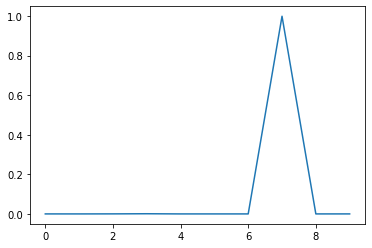

In [65]:
preds = model_exp4.predict(x_test_feature)
print('shape of preds: ', preds.shape)

index = 17
plt.plot(preds[index])
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 1152x288 with 0 Axes>

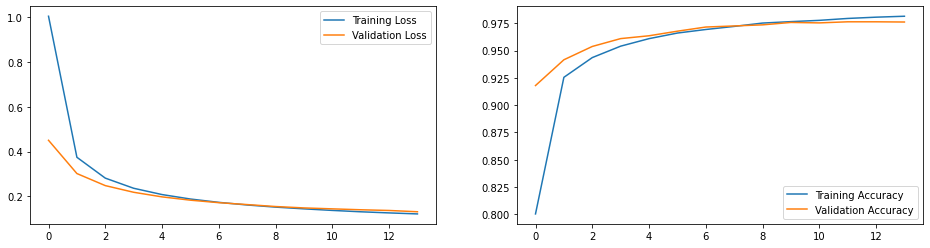

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.97      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Accuracy Score: 0.9766
Root Mean Square Error: 0.6807348970047004


array([7, 2, 1, ..., 4, 5, 6])

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 970,    0,    0,    2,    0,    2,    3,    1,    1,    1],
       [   0, 1123,    2,    1,    0,    0,    4,    1,    4,    0],
       [   5,    1, 1006,    3,    3,    0,    3,    7,    4,    0],
       [   0,    0,    5,  989,    0,    4,    0,    7,    3,    2],
       [   1,    0,    2,    0,  960,    0,    4,    2,    2,   11],
       [   4,    1,    0,    6,    1,  869,    5,    1,    2,    3],
       [   5,    3,    1,    0,    6,    6,  933,    0,    4,    0],
       [   2,    8,    8,    3,    1,    0,    0,  999,    2,    5],
       [   3,    1,    2,    5,    5,    2,    5,    6,  942,    3],
       [   4,    4,    0,    6,   10,    2,    1,    7,    0,  975]], dtype=int32)>

,0,1,2,3,4,5,6,7,8,9
0,0.00%,0.00%,0.01%,0.07%,0.00%,0.00%,0.00%,99.91%,0.00%,0.01%
1,0.07%,0.05%,99.62%,0.13%,0.00%,0.04%,0.04%,0.00%,0.04%,0.00%
2,0.00%,99.09%,0.23%,0.07%,0.05%,0.07%,0.04%,0.24%,0.20%,0.01%
3,99.86%,0.00%,0.03%,0.00%,0.00%,0.04%,0.01%,0.04%,0.00%,0.02%
4,0.02%,0.00%,0.02%,0.00%,98.78%,0.01%,0.06%,0.16%,0.01%,0.94%
5,0.00%,99.37%,0.02%,0.02%,0.02%,0.00%,0.00%,0.51%,0.06%,0.00%
6,0.00%,0.00%,0.00%,0.00%,99.52%,0.02%,0.00%,0.14%,0.23%,0.08%
7,0.00%,0.01%,0.10%,0.48%,0.49%,0.29%,0.00%,0.24%,0.09%,98.31%
8,0.09%,0.02%,5.29%,0.02%,0.59%,52.69%,36.43%,0.01%,4.62%,0.25%
9,0.00%,0.00%,0.00%,0.01%,0.64%,0.00%,0.00%,0.46%,0.21%,98.68%


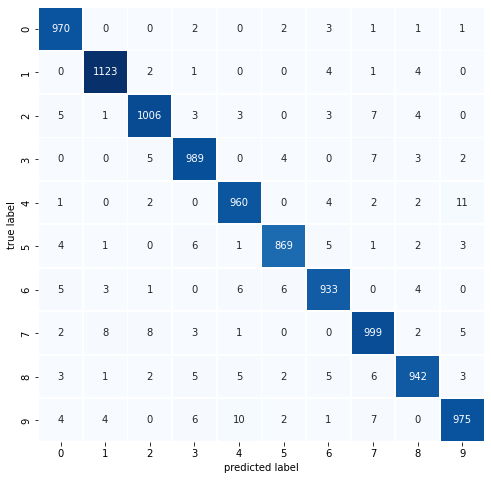

In [66]:
history_dict = history_exp4.history
history_dict.keys()

losses = history_exp4.history['loss']
accs = history_exp4.history['accuracy']
val_losses = history_exp4.history['val_loss']
val_accs = history_exp4.history['val_accuracy']
epochs = len(losses)


plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()


pred1= model_exp4.predict(x_test_feature)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)


pred_classes = np.argmax(model_exp4.predict(x_test_feature), axis=-1)
pred_classes;
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

plot_confusion_matrix(y_test,pred_classes)

## EXPERIMENT 5: 
We use a Random Forest classifier to get the relative importance of the 784 features (pixels) of the 28x28 dimensional images in training set of MNIST images and select the top 70 features (pixels). We train our 'best' dense neural network using these 70 features and compare its performance to the the dense neural network models from EXPERIMENTS 3 and 4.

<div class="alert alert-block alert-info">
    <b>sklearn.ensemble.RandomForestClassifier</b><br> 
  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    </div>

In [67]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(random_state=42)

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

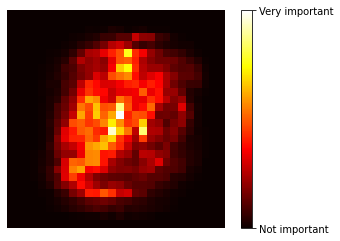

In [68]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [69]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

In [70]:
# Create training and test images using just the 70 pixel locations obtained above
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]

x_val_images_sm = train_images_sm[:5000]
partial_x_train_images_sm = train_images_sm[5000:]

train_images_sm.shape, x_val_images_sm.shape, partial_x_train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

((60000, 70), (5000, 70), (55000, 70), (10000, 70))

### Visualize the 70 pixels
We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. These are the features (pixels) we train our neural network on.

In [71]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

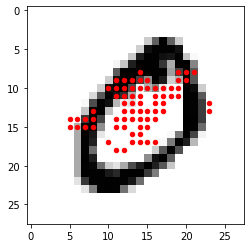

In [72]:
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)

### Model

In [73]:
# model with 128 hidden nodes and 70 important pixels
model_exp5 = Sequential([
    Dense(128, input_shape=[70], activation = tf.nn.relu,kernel_regularizer=tf.keras.regularizers.L2(0.001)), 
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

model_exp5.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

history_exp5 = model_exp5.fit(
    partial_x_train_images_sm
    ,partial_y_train
    ,epochs = 200
    ,batch_size=512
    ,validation_data=(x_val_images_sm, y_val)
    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)] 
    )

loss, accuracy = model_exp5.evaluate(test_images_sm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

Epoch 1/200
108/108 [==============================] - 1s 5ms/step - loss: 1.1203 - accuracy: 0.7239 - val_loss: 0.7288 - val_accuracy: 0.8188
Epoch 2/200
108/108 [==============================] - 0s 3ms/step - loss: 0.6870 - accuracy: 0.8250 - val_loss: 0.6221 - val_accuracy: 0.8532
Epoch 3/200
108/108 [==============================] - 0s 3ms/step - loss: 0.6131 - accuracy: 0.8464 - val_loss: 0.5705 - val_accuracy: 0.8608
Epoch 4/200
108/108 [==============================] - 0s 3ms/step - loss: 0.5648 - accuracy: 0.8602 - val_loss: 0.5250 - val_accuracy: 0.8768
Epoch 5/200
108/108 [==============================] - 0s 3ms/step - loss: 0.5288 - accuracy: 0.8699 - val_loss: 0.4994 - val_accuracy: 0.8864
Epoch 6/200
108/108 [==============================] - 0s 3ms/step - loss: 0.4996 - accuracy: 0.8778 - val_loss: 0.4791 - val_accuracy: 0.8886
Epoch 7/200
108/108 [==============================] - 0s 3ms/step - loss: 0.4762 - accuracy: 0.8839 - val_loss: 0.4571 - val_accuracy: 0.8932

shape of preds:  (10000, 10)


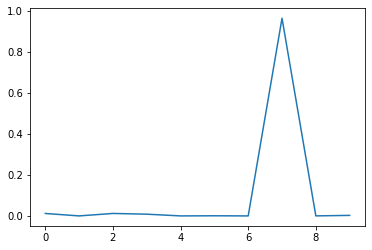

In [74]:
preds = model_exp5.predict(test_images_sm)
print('shape of preds: ', preds.shape)

index = 17
plt.plot(preds[index])
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 1152x288 with 0 Axes>

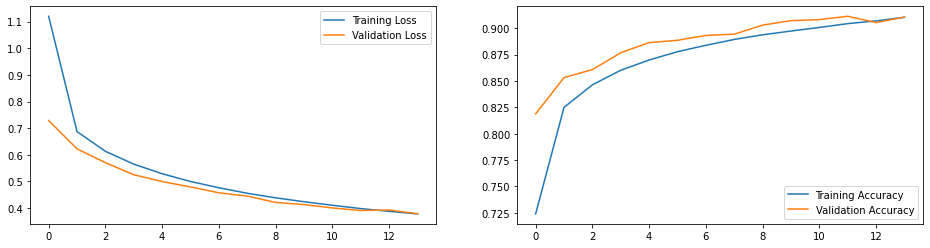

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       980
           1       0.96      0.98      0.97      1135
           2       0.89      0.90      0.89      1032
           3       0.94      0.86      0.90      1010
           4       0.90      0.90      0.90       982
           5       0.87      0.85      0.86       892
           6       0.91      0.91      0.91       958
           7       0.90      0.93      0.92      1028
           8       0.92      0.88      0.90       974
           9       0.89      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

Accuracy Score: 0.9075
Root Mean Square Error: 1.2523977004130917


array([7, 2, 1, ..., 4, 5, 6])

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[ 955,    0,    7,    0,    0,    6,    4,    6,    1,    1],
       [   0, 1117,    4,    1,    0,    4,    1,    3,    4,    1],
       [   8,   12,  926,    3,   12,   11,   13,   32,   10,    5],
       [   6,    1,   28,  873,    3,   52,    0,   16,   19,   12],
       [   3,    2,   10,    1,  879,    2,   28,    5,   10,   42],
       [  31,    9,    5,   33,   10,  755,   18,    7,   15,    9],
       [  35,    7,    6,    0,   25,    8,  868,    3,    5,    1],
       [   5,    6,   37,    4,    6,    0,    1,  955,    1,   13],
       [  12,    4,   14,    8,    9,   17,   20,    8,  858,   24],
       [   8,    7,    8,    5,   37,   15,    5,   22,   13,  889]], dtype=int32)>

,0,1,2,3,4,5,6,7,8,9
0,0.08%,0.01%,0.71%,0.28%,0.01%,0.03%,0.00%,98.47%,0.05%,0.36%
1,32.72%,0.08%,46.10%,0.18%,0.01%,0.36%,20.00%,0.00%,0.55%,0.00%
2,0.01%,98.01%,0.31%,0.09%,0.24%,0.06%,0.10%,0.91%,0.23%,0.04%
3,99.99%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
4,0.06%,0.00%,0.56%,0.01%,90.31%,0.04%,0.71%,1.71%,0.16%,6.46%
5,0.00%,98.53%,0.08%,0.03%,0.06%,0.02%,0.00%,0.97%,0.28%,0.01%
6,0.01%,0.03%,0.24%,0.97%,72.80%,0.47%,0.04%,1.32%,0.85%,23.27%
7,0.00%,0.01%,0.19%,0.37%,21.99%,0.42%,0.42%,3.10%,1.05%,72.45%
8,0.14%,0.00%,82.92%,0.44%,2.60%,3.20%,0.79%,1.54%,1.54%,6.81%
9,0.00%,0.00%,0.06%,0.02%,5.23%,0.15%,0.00%,5.72%,1.43%,87.38%


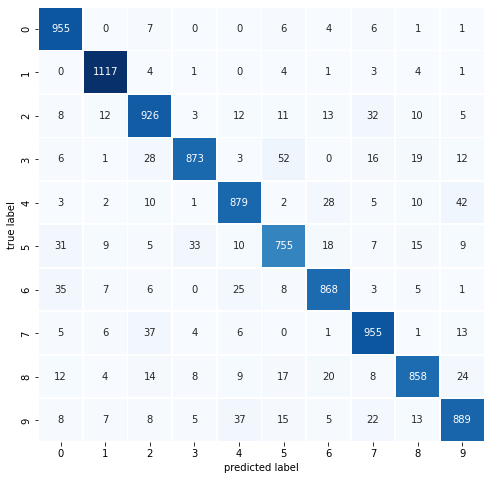

In [75]:
history_dict = history_exp5.history
history_dict.keys()

losses = history_exp5.history['loss']
accs = history_exp5.history['accuracy']
val_losses = history_exp5.history['val_loss']
val_accs = history_exp5.history['val_accuracy']
epochs = len(losses)


plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()


pred1= model_exp5.predict(test_images_sm)
pred1=np.argmax(pred1, axis=1)

print_validation_report(y_test, pred1)


pred_classes = np.argmax(model_exp5.predict(test_images_sm), axis=-1)
pred_classes;
conf_mx = tf.math.confusion_matrix(y_test, pred_classes)
conf_mx;

cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
df = pd.DataFrame(preds[0:20], columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

plot_confusion_matrix(y_test,pred_classes)